<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Alexey-Tatarinov-folder/Alexey%20Tatarinov/Iris_Final_Notebook_27_06_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Задача идентификации пациента по радужной оболочке глаза (Iris ID)**



**Постановка задачи**

Необходимо построить нейронную сеть и обучить ее, подав на нее изображения радужной оболочки правого и левого глаза 64 пациентов

**Описание данных**

Данные, используемые для идентификации пациента:
Цветные изображения переднего сегмента глаз в формате png. В качестве источника датасета задействованы 64
человека.
Задействованных людей можно использовать для тестирования
обученной сети.

**Гипотезы и эксперименты**

Для решения задачи проводились эксперименты с архитектурой нейронной сети:

1) Проверено около 15-20 различных архитектур методом ручного подбора оптимальных слоев для получения наибольшей точности (accuracy) на тестовых изображениях, а также перебраны гиперпараметры для каждой из данных архитектур.

2) Проверена и проанализирована точность моделей, построенных с помощью AutoML, а именно AutoKeras, на основе графиков функции потерь и точности.

3) Получены и проанализированы графики функции потерь и точности нейронной сети, в архитектуре которой использована предобученная модель.

## **Импорт библиотек и модулей**
Импортируем все библиотеки и модули, необходимые для выполнения задачи. Если библиотеки и модули не установлены, то устанавливаем их.

In [29]:
import gdown

import os

! pip install autokeras
import autokeras as ak

! pip install Augmentor
import Augmentor

import zipfile

import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten,
                                     Dropout, BatchNormalization, Rescaling,
                                     GlobalAveragePooling2D, RandomFlip, Input,
                                     RandomRotation, RandomZoom, RandomContrast)

from tensorflow.keras.applications import VGG19, ResNet50, Xception

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                 DirectoryIterator)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder

from PIL import Image, ImageEnhance

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Задание гиперпараметров**
В данном блоке задаем гиперпараметры, которые будем использовать для решения задачи.

In [2]:
PATH          = '/content/drive/MyDrive/iris_ds'
PATH_AUG      = '/content/drive/MyDrive/Iris'
TRAIN_VAL_PATH_AUG = '/content/drive/MyDrive/Iris_train_val_aug'
TRAIN_VAL_PATH = '/content/drive/MyDrive/iris_ds_train_val'
TEST_PATH = '/content/drive/MyDrive/iris_ds_test'

VAL_SPLIT           = 0.2

IMG_WIDTH_1         = 160
IMG_HEIGHT_1        = 120
IMG_WIDTH_2         = 80
IMG_HEIGHT_2        = 60
IMG_CHANNELS        = 3

# ROTATION_RANGE      = 10
# WIDTH_SHIFT_RANGE   = 0.1
# HEIGHT_SHIFT_RANGE  = 0.1
# ZOOM_RANGE          = 0.1
# BRIGHTNESS_RANGE    = (0.5, 1.3)
# HORIZONTAL_FLIP     = False

EPOCHS              = 20
BATCH_SIZE          = 24
OPTIMIZER_LEGACY    = tf.keras.optimizers.legacy.Adam(0.0001)
OPTIMIZER           = tf.keras.optimizers.Adam(0.0001)

## **Подготовка датасета**
В этом блоке проводится подготовка, аугментация и парсинг датасета для подачи в модель нейронной сети.

### Загрузка датасета
Подключаемся к google disk для загрузки изображений.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Распределение изображений по директориям
Подготавливаем изображения для подачи в модель нейронной сети, для этого делим изображения по директориям, а именно 5 изображений глаз каждого пациента переносим в папку с тренировочными и проверочными данными iris_ds_train_val, одно оставшееся изображение переносим в папку с тестовыми изображениями iris_ds_test. В данных папках изображения сразу распределяем по папкам соответствующим номеру клиента (client_1).

In [ ]:
import os
import shutil

# Создание целевых папок, если они не существуют
os.makedirs(TEST_PATH, exist_ok=True)
os.makedirs(TRAIN_VAL_PATH, exist_ok=True)

# Получение списка подпапок в папке PATH
subfolders = [f for f in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, f))]

# Обработка каждой подпапки
for subfolder in subfolders:
    # Путь к исходной папке клиента
    client_folder = os.path.join(PATH, subfolder)

    # Путь к папке клиента в '/content/drive/MyDrive/iris_ds_test'
    target_client_folder_1 = os.path.join(TEST_PATH, subfolder)
    os.makedirs(target_client_folder_1, exist_ok=True)

    # Путь к папке клиента в '/content/drive/MyDrive/iris_ds_train_val'
    target_client_folder_2 = os.path.join(TRAIN_VAL_PATH, subfolder)
    os.makedirs(target_client_folder_2, exist_ok=True)

    # Получение списка файлов в папке клиента
    files = os.listdir(client_folder)

    # Копирование первого файла в '/content/drive/MyDrive/iris_ds_test'
    first_file = files[0]
    source_path = os.path.join(client_folder, first_file)
    target_path = os.path.join(target_client_folder_1, first_file)
    shutil.copyfile(source_path, target_path)

    # Копирование оставшихся пяти файлов в '/content/drive/MyDrive/iris_ds_train_val'
    remaining_files = files[1:]
    for file in remaining_files:
        source_path = os.path.join(client_folder, file)
        target_path = os.path.join(target_client_folder_2, file)
        shutil.copyfile(source_path, target_path)

### Аугментация
С помощью данного кода осуществляется аугментация только тренировочных и проверочных изображений (из папки iris_ds_train_val) и сохраняется в новую папку Iris_train_val_aug. Аугментация проводится до 50 изображений для каждого клиента. При этом для каждого изображения:
- с вероятностью 20 процентов происходит вращение изображения вправо или влево на угол не более 10 градусов;
- с вероятностью 10 процентов производится обрезание зображения;
- с вероятностью 50 процентов производится небольшое снижение или увеличение яркости изображения;
- с вероятностью 50 процентов производится небольшое снижение или увеличение контраста изображения.
В результате получено 3200 изображений по 50 изображений на каждого из 64 клиентов.

In [ ]:
for folder in os.listdir(TRAIN_VAL_PATH):
    if os.path.isdir(os.path.join(TRAIN_VAL_PATH, folder)):
        # Создаем генератор аугментации для каждой папки
        p = Augmentor.Pipeline(os.path.join(TRAIN_VAL_PATH, folder), output_directory=os.path.join(f'/content/drive/MyDrive/Iris_train_val_aug/{folder}'))
        # Добавляем операции аугментации
        # Вращение изображения
        p.rotate(probability=0.2, max_left_rotation=10, max_right_rotation=10)
        # увеличение
        #p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
        # Обрезание изображения
        p.crop_random(probability=0.1, percentage_area=0.95)
        # Изменение яркости
        p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
        # Изменение контрасности
        p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
        # Применяем аугментацию
        p.sample(50)
print('Аугментация завершена')

### Создание базы
В этом блоке выполняется изменение размера изображений до оптимального для выполнения данной задачи, а затем сборка датасета необходимой формы отдельно для тренировочных/проверочных данных и отдельно для неаугментированных тестовых данных.

In [4]:
CLASS_LIST = sorted(os.listdir(TRAIN_VAL_PATH_AUG))
CLASS_COUNT = len(CLASS_LIST)

print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 64, метки классов: ['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_63', 'client_64', 'client_7', 'client_8', 'client_9']


In [5]:
data_files = []
data_labels = []

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = f'{TRAIN_VAL_PATH_AUG}/{class_name}'  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]
    data_labels += [class_label] * len(class_files)
    print(f'Размер класса {class_name} составляет {len(class_files)} снимков')

print('Общий размер базы для обучения:', len(data_labels))

Размер класса client_1 составляет 50 снимков
Размер класса client_10 составляет 50 снимков
Размер класса client_11 составляет 50 снимков
Размер класса client_12 составляет 50 снимков
Размер класса client_13 составляет 50 снимков
Размер класса client_14 составляет 50 снимков
Размер класса client_15 составляет 50 снимков
Размер класса client_16 составляет 50 снимков
Размер класса client_17 составляет 50 снимков
Размер класса client_18 составляет 50 снимков
Размер класса client_19 составляет 50 снимков
Размер класса client_2 составляет 50 снимков
Размер класса client_20 составляет 50 снимков
Размер класса client_21 составляет 50 снимков
Размер класса client_22 составляет 50 снимков
Размер класса client_23 составляет 50 снимков
Размер класса client_24 составляет 50 снимков
Размер класса client_25 составляет 50 снимков
Размер класса client_26 составляет 50 снимков
Размер класса client_27 составляет 50 снимков
Размер класса client_28 составляет 50 снимков
Размер класса client_29 составляет 5

In [6]:
data_images = []

for file_name in data_files:
    img = Image.open(file_name).resize((IMG_WIDTH_2, IMG_HEIGHT_2))
    img_np = np.array(img)
    data_images.append(img_np)

x_data_small = np.array(data_images)
y_data = np.array(data_labels)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data_small.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 3200 фотографий следующей формы: (60, 80, 3)
Общий массив данных изображений следующей формы: (3200, 60, 80, 3)
Общий массив меток классов следующей формы: (3200,)


In [7]:
CLASS_LIST_TEST = sorted(os.listdir(TEST_PATH))
CLASS_COUNT_TEST = len(CLASS_LIST_TEST)

print(f'Количество классов: {CLASS_COUNT_TEST}, метки классов: {CLASS_LIST_TEST}')

Количество классов: 64, метки классов: ['client_1', 'client_10', 'client_11', 'client_12', 'client_13', 'client_14', 'client_15', 'client_16', 'client_17', 'client_18', 'client_19', 'client_2', 'client_20', 'client_21', 'client_22', 'client_23', 'client_24', 'client_25', 'client_26', 'client_27', 'client_28', 'client_29', 'client_3', 'client_30', 'client_31', 'client_32', 'client_33', 'client_34', 'client_35', 'client_36', 'client_37', 'client_38', 'client_39', 'client_4', 'client_40', 'client_41', 'client_42', 'client_43', 'client_44', 'client_45', 'client_46', 'client_47', 'client_48', 'client_49', 'client_5', 'client_50', 'client_51', 'client_52', 'client_53', 'client_54', 'client_55', 'client_56', 'client_57', 'client_58', 'client_59', 'client_6', 'client_60', 'client_61', 'client_62', 'client_63', 'client_64', 'client_7', 'client_8', 'client_9']


In [8]:
data_files_test = []
data_labels_test = []

for class_label_test in range(CLASS_COUNT_TEST):    # Для всех классов по порядку номеров (их меток)
    class_name_test = CLASS_LIST_TEST[class_label_test]  # Выборка имени класса из списка имен
    class_path_test = f'{TEST_PATH}/{class_name_test}'  # Формирование полного пути к папке с изображениями класса
    class_files_test = os.listdir(class_path_test)  # Получение списка имен файлов с изображениями текущего класса
    data_files_test += [f'{class_path_test}/{file_name}' for file_name in class_files_test]
    data_labels_test += [class_label_test] * len(class_files_test)
    print(f'Размер класса {class_name_test} составляет {len(class_files_test)} снимков')

print('Общий размер базы для проверки:', len(data_labels_test))

Размер класса client_1 составляет 1 снимков
Размер класса client_10 составляет 1 снимков
Размер класса client_11 составляет 1 снимков
Размер класса client_12 составляет 1 снимков
Размер класса client_13 составляет 1 снимков
Размер класса client_14 составляет 1 снимков
Размер класса client_15 составляет 1 снимков
Размер класса client_16 составляет 1 снимков
Размер класса client_17 составляет 1 снимков
Размер класса client_18 составляет 1 снимков
Размер класса client_19 составляет 1 снимков
Размер класса client_2 составляет 1 снимков
Размер класса client_20 составляет 1 снимков
Размер класса client_21 составляет 1 снимков
Размер класса client_22 составляет 1 снимков
Размер класса client_23 составляет 1 снимков
Размер класса client_24 составляет 1 снимков
Размер класса client_25 составляет 1 снимков
Размер класса client_26 составляет 1 снимков
Размер класса client_27 составляет 1 снимков
Размер класса client_28 составляет 1 снимков
Размер класса client_29 составляет 1 снимков
Размер класс

In [9]:
data_images_test = []

for file_name in data_files_test:
    img_test = Image.open(file_name).resize((IMG_WIDTH_2, IMG_HEIGHT_2))
    img_np_test = np.array(img_test)
    data_images_test.append(img_np_test)

x_data_test = np.array(data_images_test)
y_data_test = np.array(data_labels_test)

print(f'В массив собрано {len(data_images_test)} фотографий следующей формы: {img_np_test.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data_test.shape}')
print(f'Общий массив меток классов следующей формы: {y_data_test.shape}')

В массив собрано 64 фотографий следующей формы: (60, 80, 3)
Общий массив данных изображений следующей формы: (64, 60, 80, 3)
Общий массив меток классов следующей формы: (64,)


### Деление на выборки
В данном блоке аугментированный датасет с тренировочными и проверочными изображениями Iris_train_val_aug делим на тренировочную и проверочную выборку. Метки преобразуем в формат one hot encoding. В результате получаем размерности тренировочного, проверочного и тестового датасета.

In [10]:
x_train_small, x_val_small, y_train_small, y_val_small = train_test_split(x_data_small, y_data, test_size=0.2, random_state=42)


In [11]:
y_train_small = to_categorical(y_train_small)
y_val_small = to_categorical(y_val_small)
y_data_test = to_categorical(y_data_test)

In [12]:
print('\nРазмерности датасетов с изображениями 80 на 60')
print('Тренировочный датасет:')
print(x_train_small.shape)
print(y_train_small.shape)
print('Проверочный датасет:')
print(x_val_small.shape)
print(y_val_small.shape)
print('Тестовый датасет:')
print(x_data_test.shape)
print(y_data_test.shape)


Размерности датасетов с изображениями 80 на 60
Тренировочный датасет:
(2560, 60, 80, 3)
(2560, 64)
Проверочный датасет:
(640, 60, 80, 3)
(640, 64)
Тестовый датасет:
(64, 60, 80, 3)
(64, 64)


## **Оптимизация обучения моделей**
Добавляем checkpoint для возможности сохранения промежуточных результатов модели.

In [13]:
checkpoint = ModelCheckpoint(filepath="my_model.hdf5", monitor="val_loss", verbose=0, save_best_only=True)

## **Проверка первой гипотезы**
В этом блоке проверяется гипотеза построения модели с помощью ручного подбора архитектуры, а именно оптимальных слоев и параметров для получения наибольшей точности (accuracy).

### **Работа с моделью**


### Архитектура модели
Здесь непосредственно прописан код с архитектурой модели


In [14]:
image_shape_small = x_train_small.shape[1:]
# image_shape_big = x_train_big.shape[1:]

model_1 = Sequential()
model_1.add(Conv2D(128, (3, 3), activation='relu', input_shape=image_shape_small))
model_1.add(MaxPooling2D((2, 2)))
# model_1.add(BatchNormalization())
# model_1.add(Dropout(0.2))
model_1.add(Conv2D(256, (3, 3), activation='relu', input_shape=image_shape_small))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))
# model_1.add(BatchNormalization())
# model_1.add(Dropout(0.2))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(CLASS_COUNT, activation='softmax'))

### Обучение модели
В этой части ноутбука происходит компиляция и обучение модели на 20 эпохах

In [17]:
model_1.compile(
              optimizer=OPTIMIZER_LEGACY,
              loss='categorical_crossentropy',
              metrics='accuracy')


In [18]:
history_small = model_1.fit(
                          x_train_small,
                          y_train_small,
                          epochs=20,
                          validation_data=(x_val_small, y_val_small),
                          callbacks=checkpoint,
                          )

Epoch 1/20
80/80 [==============================] - 12s 22ms/step - loss: 4.6798 - accuracy: 0.0508 - val_loss: 3.6248 - val_accuracy: 0.1172
Epoch 2/20
80/80 [==============================] - 2s 19ms/step - loss: 3.2185 - accuracy: 0.2199 - val_loss: 2.7564 - val_accuracy: 0.3172
Epoch 3/20
80/80 [==============================] - 1s 19ms/step - loss: 2.1192 - accuracy: 0.4574 - val_loss: 1.7576 - val_accuracy: 0.5000
Epoch 4/20
80/80 [==============================] - 2s 19ms/step - loss: 1.2393 - accuracy: 0.6734 - val_loss: 1.0482 - val_accuracy: 0.7453
Epoch 5/20
80/80 [==============================] - 2s 19ms/step - loss: 0.7533 - accuracy: 0.8105 - val_loss: 0.7360 - val_accuracy: 0.8000
Epoch 6/20
80/80 [==============================] - 2s 19ms/step - loss: 0.4586 - accuracy: 0.8875 - val_loss: 0.5112 - val_accuracy: 0.8687
Epoch 7/20
80/80 [==============================] - 2s 20ms/step - loss: 0.3199 - accuracy: 0.9223 - val_loss: 0.4084 - val_accuracy: 0.8969
Epoch 8/20
8

### **Проверка модели**
В этом блоке кода сначала выводится архитектура модели, затем визуализируем с помощью графиков, после чего проверяем на тестовых данных и строим матрицу ошибок.

### Визуализация работы модели
Здесь выводится информация по архитектуре модели и строится два графика:
- точности на обучающей и проверочной выборке;
- функции потерь на обучающей и проверочной выборке.

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 78, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 39, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 18, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 16, 128)       295040    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 8, 128)        0

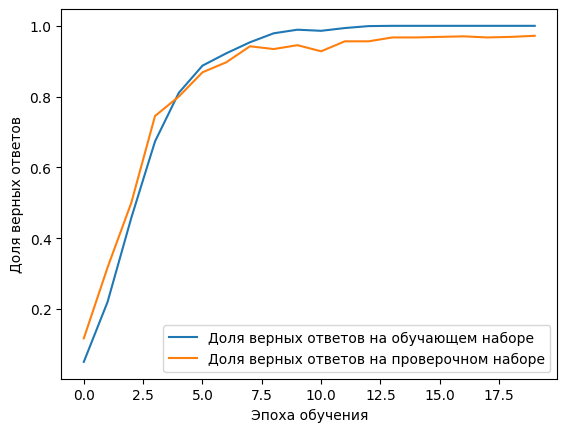

In [20]:
# Визуализация точности на обучающей выборке
plt.plot(history_small.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history_small.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()

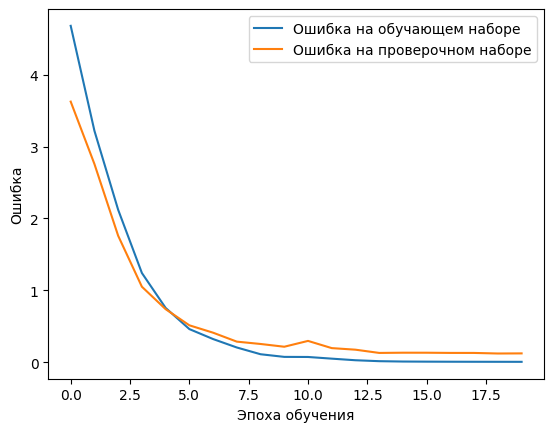

In [21]:
# Визуализация потерь на обучающей выборке
plt.plot(history_small.history['loss'],
         label='Ошибка на обучающем наборе')

# Визуализация потерь на проверочной выборке
plt.plot(history_small.history['val_loss'],
         label='Ошибка на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

### Проверка на тестовых данных
Проверяем работу модели на тестовом датасете и получаем точность на нем.

In [22]:
scores_small = model_1.evaluate(x_data_test,
                                y_data_test,
                                verbose=1
                                )

print('Процент верных ответов на тестовых данных размером 80 на 60:', round(scores_small[1],4) * 100, '%')

2/2 [==============================] - 0s 13ms/step - loss: 1.0492 - accuracy: 0.8125
Процент верных ответов на тестовых данных размером 80 на 60: 81.25 %


### Предсказания модели
Пробуем сделать предсказание модели и сравниваем его с правильным ответом.

In [23]:
x = x_data_test[5]
print(x.shape)

x = np.expand_dims(x, axis=0)
print(x.shape)

prediction = model_1.predict(x)
print(prediction)

pred = np.argmax(prediction)
print(f'Распознан пациент: {pred}')
print(f'Настоящий пациент: {np.argmax(y_data_test[5])}')

(60, 80, 3)
(1, 60, 80, 3)
1/1 [==============================] - 0s 290ms/step
[[3.4561614e-11 6.8462411e-17 3.1032408e-07 1.4959628e-14 4.3154552e-07
  9.9497581e-01 3.9014836e-08 1.6229028e-07 5.8138561e-09 1.7613808e-03
  1.0892008e-03 3.3512937e-09 5.7276061e-06 3.5188963e-10 7.3310507e-12
  3.8078393e-14 1.0675013e-05 1.5507012e-05 3.5823661e-13 1.6676948e-08
  4.0390113e-12 2.1617849e-10 5.0525500e-10 4.2470749e-11 5.2475718e-10
  9.6584919e-12 5.2936222e-05 8.3946383e-10 4.2959523e-06 8.6270218e-09
  1.6800239e-09 1.9320235e-15 5.3160893e-09 2.6373705e-11 3.5496186e-08
  1.5203869e-11 3.0767744e-13 4.1544702e-08 8.1536653e-22 3.2599707e-04
  9.8652668e-09 2.0618670e-12 5.8721081e-09 8.4000767e-08 7.6794875e-13
  1.1889863e-07 6.1884639e-05 6.1997450e-13 4.2190929e-10 5.4443932e-15
  5.2672961e-14 2.4554028e-08 2.5863274e-09 1.3175702e-12 9.3747838e-07
  1.4719101e-11 7.9214116e-18 5.1415668e-08 1.7495017e-14 1.3540802e-03
  8.5201513e-14 3.2985775e-04 1.0255248e-05 1.5092621e-0

### Матрица ошибок
Для анализа полученной модели строим матрицу ошибок.

2/2 [==============================] - 0s 9ms/step


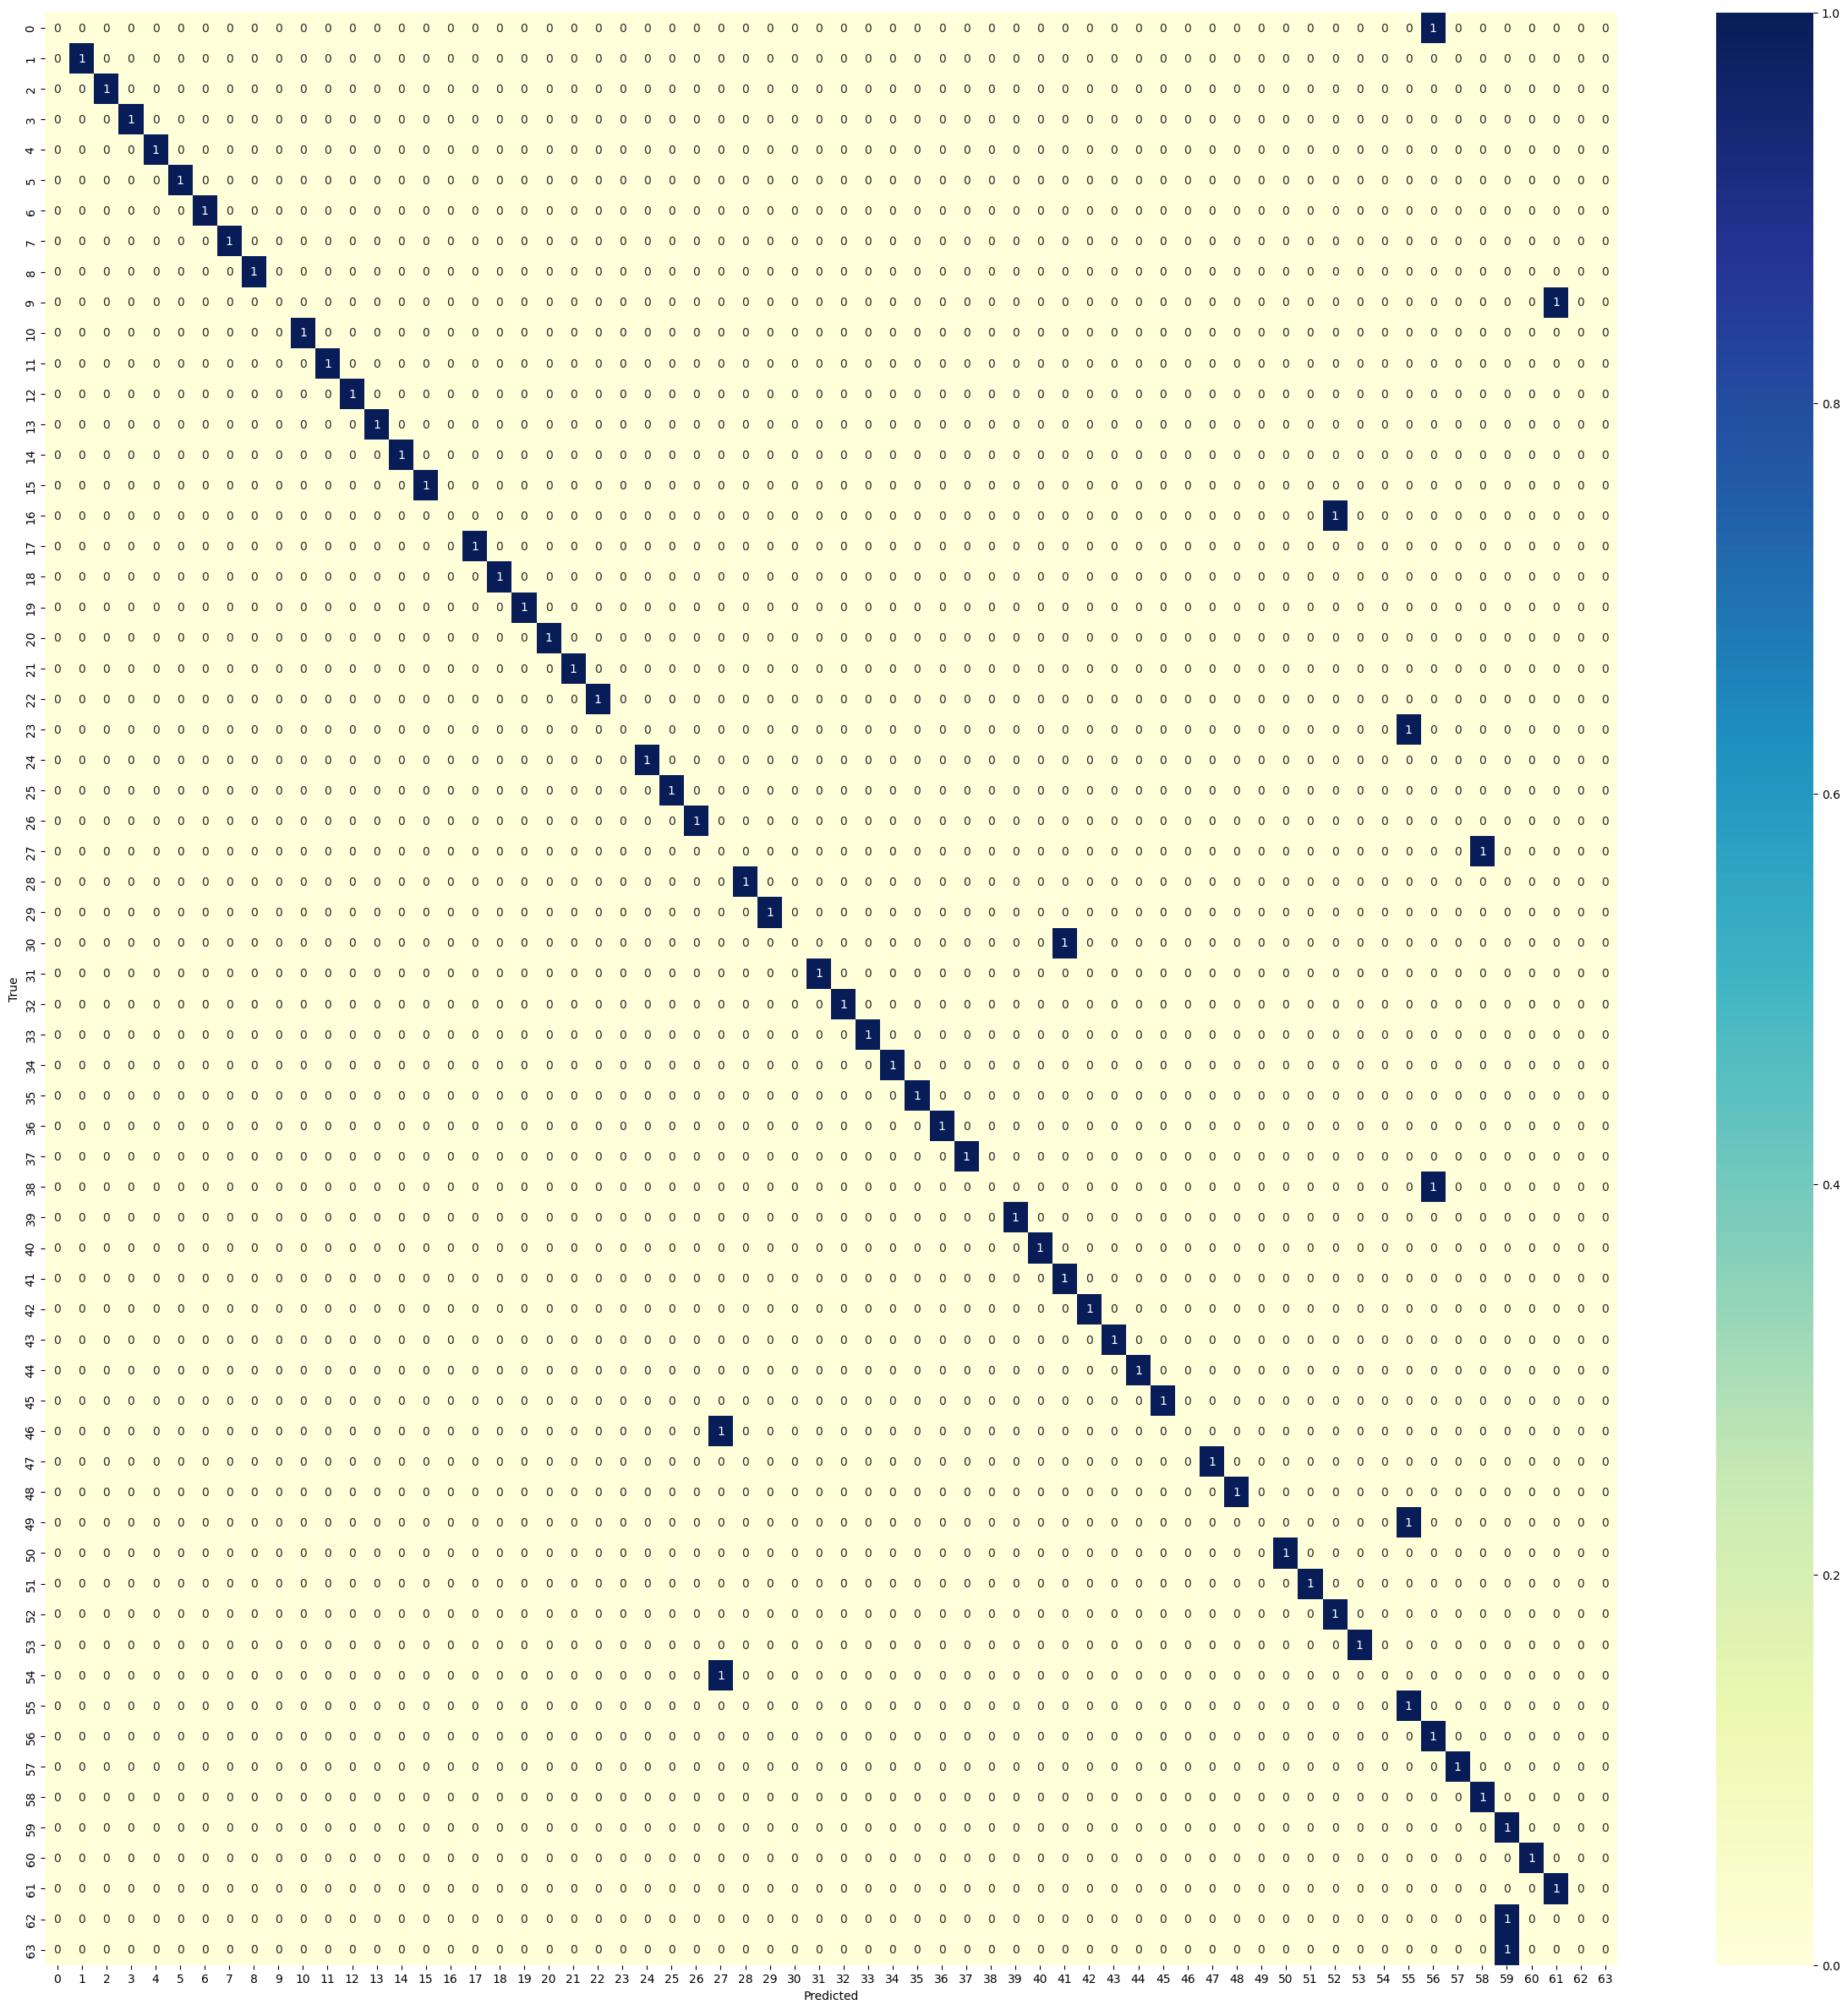

In [26]:
# Вычисление матрицы ошибок
y_pred = model_1.predict(x_data_test)
y_test_classes = [tf.argmax(y_data_test[i]).numpy() for i in range(len(y_data_test))]
y_pred_classes = [tf.argmax(y_pred[i]).numpy() for i in range(len(y_pred))]
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

# Отображение матрицы ошибок в графическом виде
plt.figure(figsize=(30,30))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Проверка второй гипотезы**
В этом блоке проверяется гипотеза построения модели с помощью AutoML, а именно AutoKeras для получения наибольшей точности (accuracy).

### **Работа с моделью**

### Обучение модели
В этой части ноутбука происходит обучение модели, Autokeras подбирает оптимальную модель по результатам двух попыток, на 10 эпохах каждая.

In [30]:
clf = ak.ImageClassifier(
    max_trials=2,
    objective='val_accuracy',
    directory='automl_irisID_1',
    overwrite=True)

clf.fit(x_train_small,
        y_train_small,
        epochs=10,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            patience=3,
            restore_best_weights=True
            )],
        validation_data=(x_val_small, y_val_small))

Trial 2 Complete [00h 05m 21s]
val_accuracy: 0.26875001192092896

Best val_accuracy So Far: 0.984375
Total elapsed time: 00h 05m 52s


In [31]:
clf.export_model().save('/content/drive/MyDrive/model_autokeras_final')

### **Проверка модели**
В этом блоке кода сначала выводится архитектура модели,  после чего проверяем модель на тестовых данных и строим матрицу ошибок.

### Визуализация архитектуры модели
Здесь выводится информация по архитектуре модели

In [32]:
best_model = clf.export_model()
best_model.summary()
model = tf.keras.models.load_model('/content/drive/MyDrive/model_autokeras_final')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 80, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 60, 80, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 60, 80, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 58, 78, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 76, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 38, 64)       0     

### Проверка на тестовых данных
Проверяем работу модели на тестовом датасете и получаем точность на нем.

In [35]:
scores_small = best_model.evaluate(x_data_test,
                                   y_data_test,
                                   verbose=1
                                   )

print('Процент верных ответов на тестовых данных размером 80 на 60:', round(scores_small[1],4) * 100, '%')

2/2 [==============================] - 0s 31ms/step - loss: 0.6302 - accuracy: 0.9062
Процент верных ответов на тестовых данных размером 80 на 60: 90.62 %


### Предсказание модели
Пробуем сделать предсказание модели и сравниваем его с правильным ответом.

In [36]:
x = x_data_test[50]
print(x.shape)

x = np.expand_dims(x, axis=0)
print(x.shape)

prediction = clf.predict(x)
print(prediction)

pred = np.argmax(prediction)
print(f'Распознан пациент: {pred}')
print(f'Настоящий пациент: {np.argmax(y_data_test[50])}')

(60, 80, 3)
(1, 60, 80, 3)
1/1 [==============================] - 0s 10ms/step
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Распознан пациент: 50
Настоящий пациент: 50


### Матрица ошибок
Для анализа полученной модели строим матрицу ошибок.

2/2 [==============================] - 0s 7ms/step


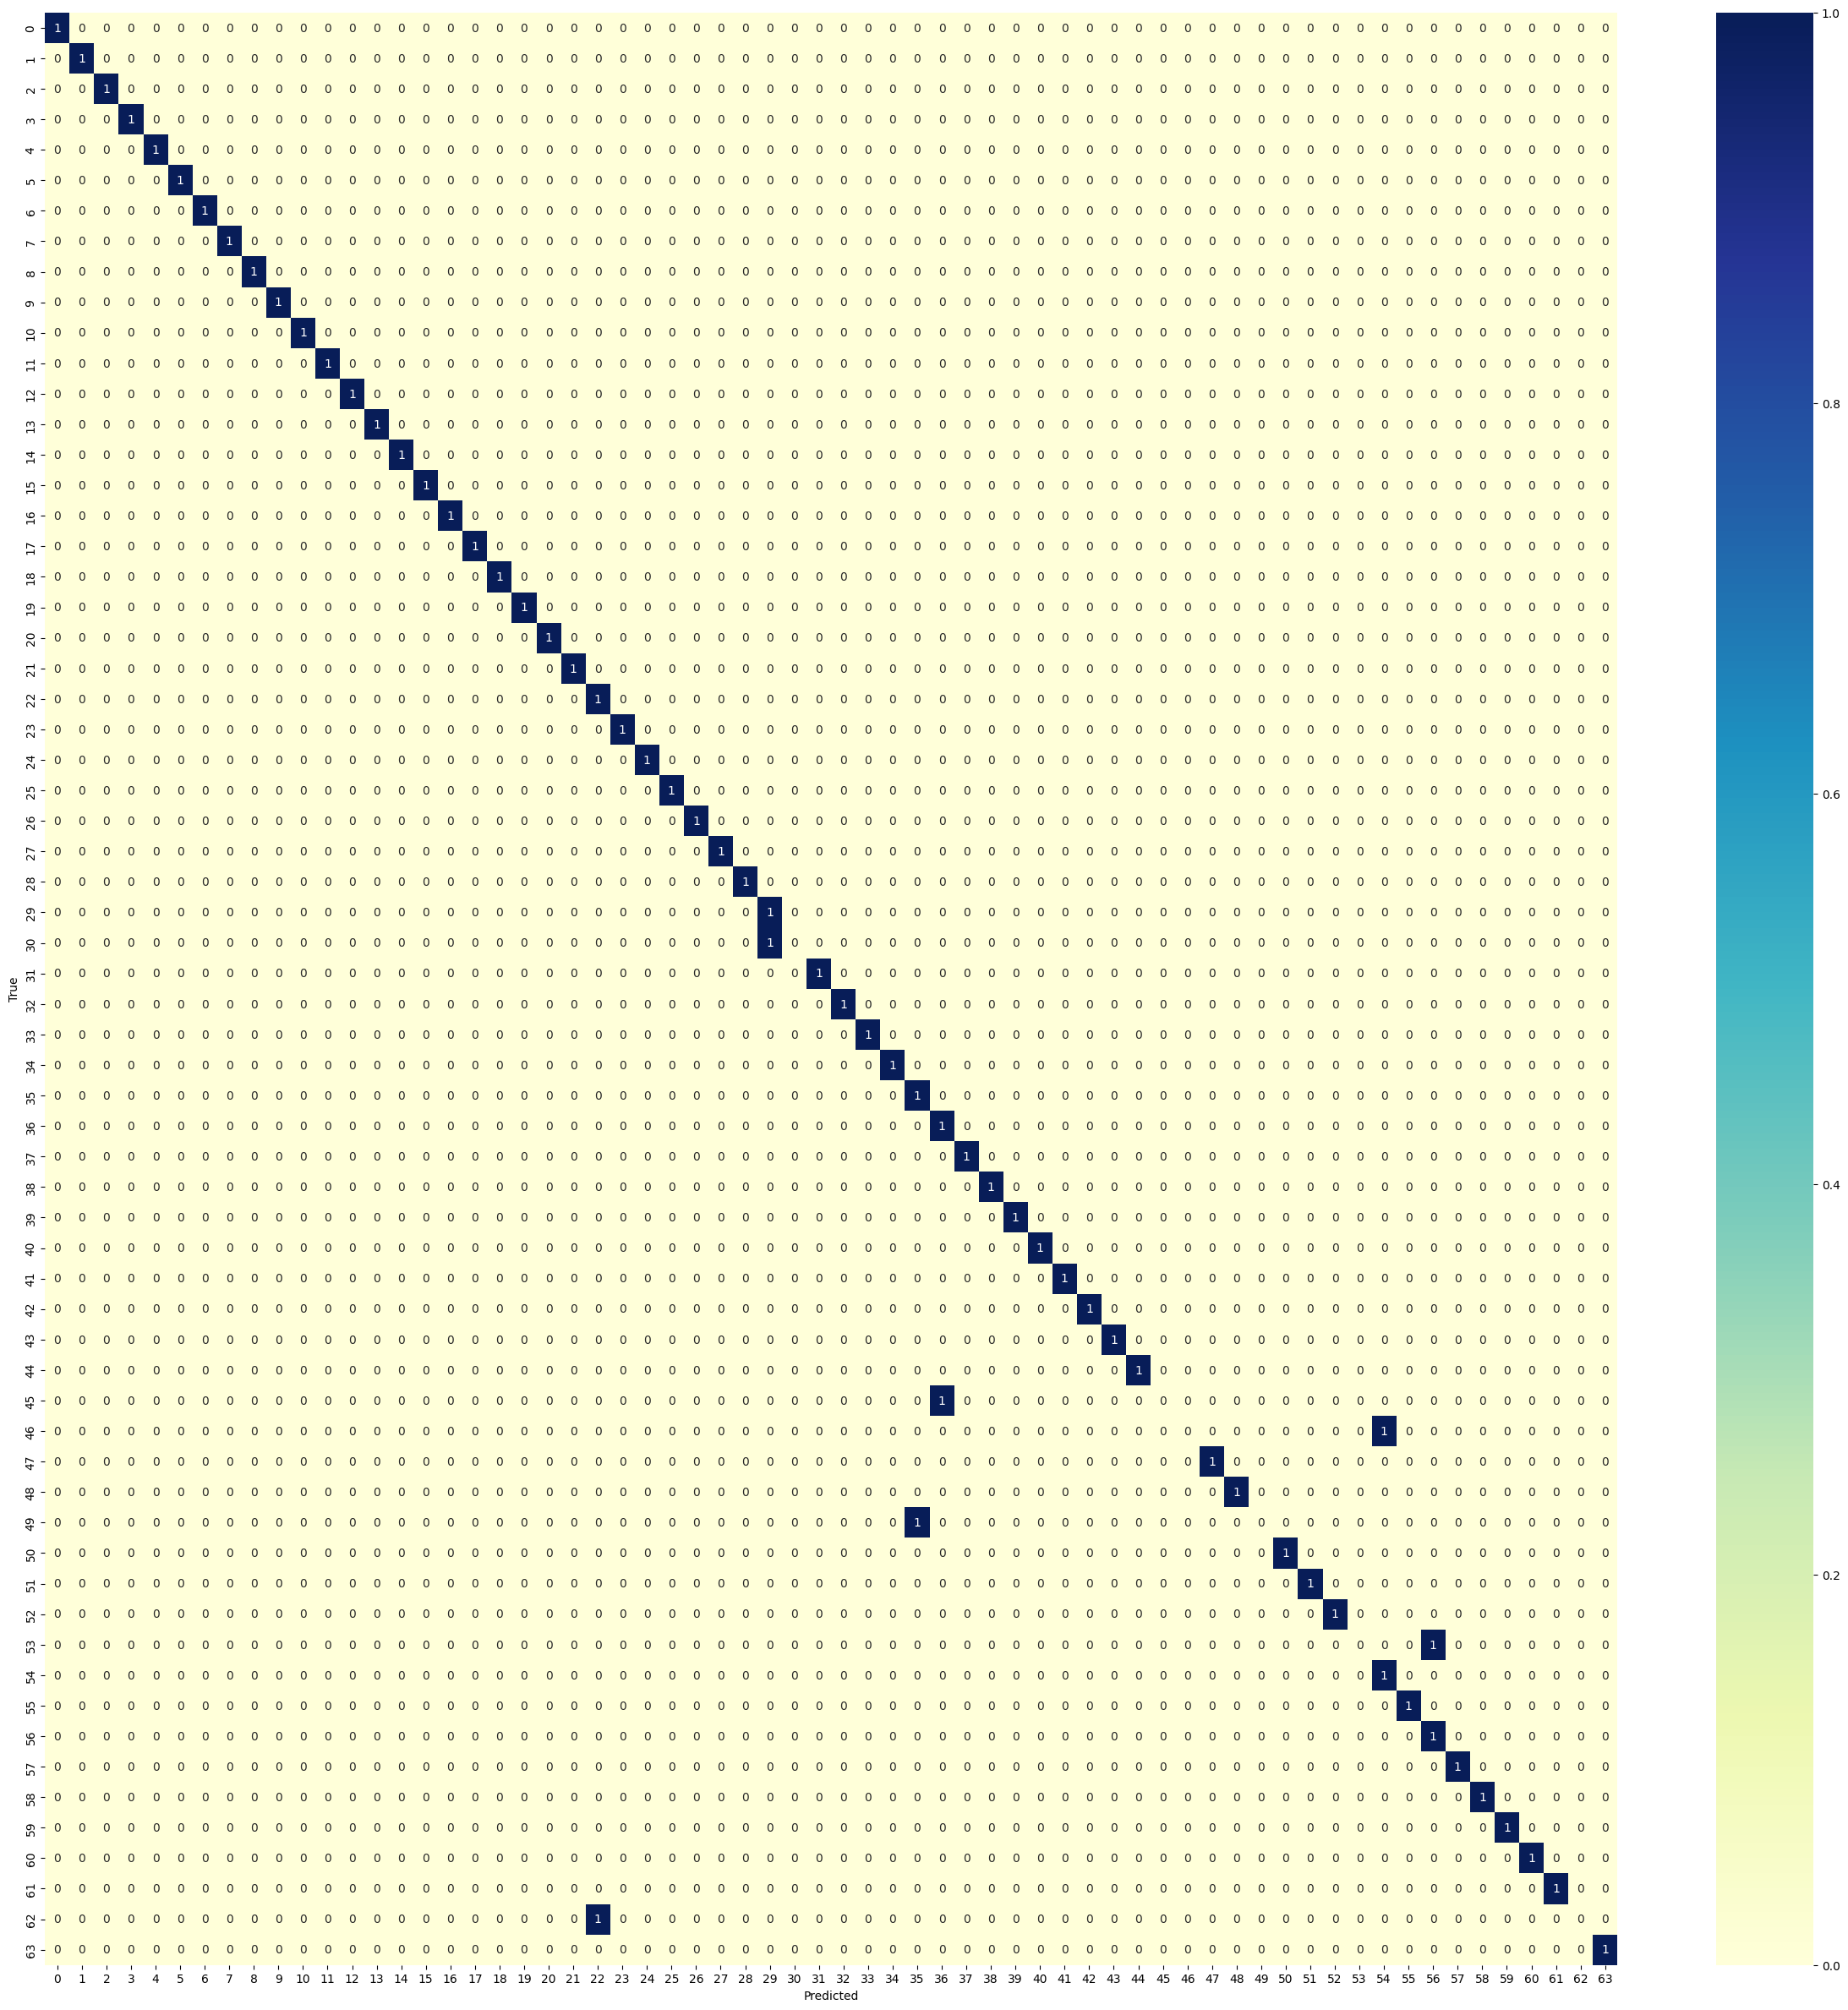

In [38]:
# Вычисление матрицы ошибок
y_pred = best_model.predict(x_data_test)
y_test_classes = [tf.argmax(y_data_test[i]).numpy() for i in range(len(y_data_test))]
y_pred_classes = [tf.argmax(y_pred[i]).numpy() for i in range(len(y_pred))]
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

# Отображение матрицы ошибок в графическом виде
plt.figure(figsize=(30,30))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Проверка третьей гипотезы**
В этом блоке проверяется гипотеза построения модели с помощью предобученной модели Resnet50 для получения наибольшей точности (accuracy).

### **Работа с моделью**

### Архитектура модели
Здесь непосредственно прописан код с архитектурой модели

In [39]:
resnet50_preprocess_input = tf.keras.applications.resnet50.preprocess_input
resnet50_layer = tf.keras.applications.resnet50.ResNet50(input_shape=x_train_small.shape[1:],
                         include_top=False,
                         weights='imagenet')

inputs = tf.keras.Input(shape=x_train_small.shape[1:])
x = resnet50_preprocess_input(inputs)
x = resnet50_layer(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

outputs = Dense(64, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 5s 0us/step


### Обучение модели
В этой части ноутбука происходит компиляция и обучение модели на 20 эпохах.

In [40]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics='accuracy')

In [41]:
history_resnet = model.fit(
                          x_train_small,
                          y_train_small,
                          validation_data=(x_val_small, y_val_small),
                          epochs=20,
                          callbacks=checkpoint,
                          )

Epoch 1/20
80/80 [==============================] - 48s 83ms/step - loss: 3.6813 - accuracy: 0.1230 - val_loss: 1.8038 - val_accuracy: 0.4797
Epoch 2/20
80/80 [==============================] - 6s 70ms/step - loss: 0.7214 - accuracy: 0.7910 - val_loss: 0.2373 - val_accuracy: 0.9312
Epoch 3/20
80/80 [==============================] - 7s 90ms/step - loss: 0.1962 - accuracy: 0.9453 - val_loss: 0.0533 - val_accuracy: 0.9828
Epoch 4/20
80/80 [==============================] - 6s 80ms/step - loss: 0.0489 - accuracy: 0.9832 - val_loss: 0.0068 - val_accuracy: 0.9969
Epoch 5/20
80/80 [==============================] - 7s 86ms/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0066 - val_accuracy: 0.9969
Epoch 6/20
80/80 [==============================] - 5s 65ms/step - loss: 0.0244 - accuracy: 0.9910 - val_loss: 0.0317 - val_accuracy: 0.9953
Epoch 7/20
80/80 [==============================] - 5s 69ms/step - loss: 0.0365 - accuracy: 0.9891 - val_loss: 0.0496 - val_accuracy: 0.9891
Epoch 8/20
8

In [42]:
model_resnet50 = model.save_weights(filepath='model_weights_resnet50.h5')

In [43]:
model.load_weights(filepath='model_weights_resnet50.h5')

### **Проверка модели**
В этом блоке кода сначала выводится архитектура модели, затем визуализируем с помощью графиков, после чего проверяем на тестовых данных и строим матрицу ошибок.

### Визуализация результатов работы модели
Здесь выводится информация по архитектуре модели и строится два графика:
- точности на обучающей и проверочной выборке;
- функции потерь на обучающей и проверочной выборке.

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 80, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 60, 80, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 60, 80, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 2, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

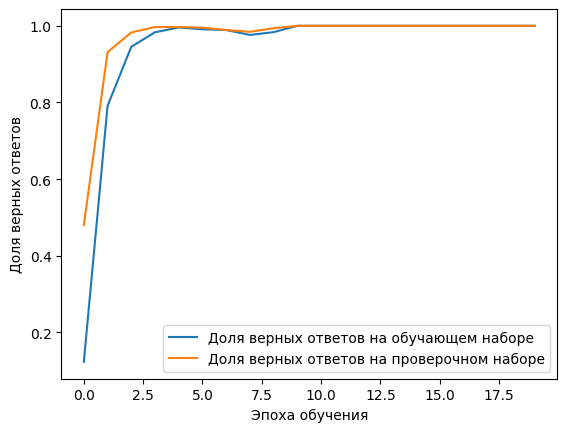

In [45]:
# Визуализация точности на обучающей выборке
plt.plot(history_resnet.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history_resnet.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()

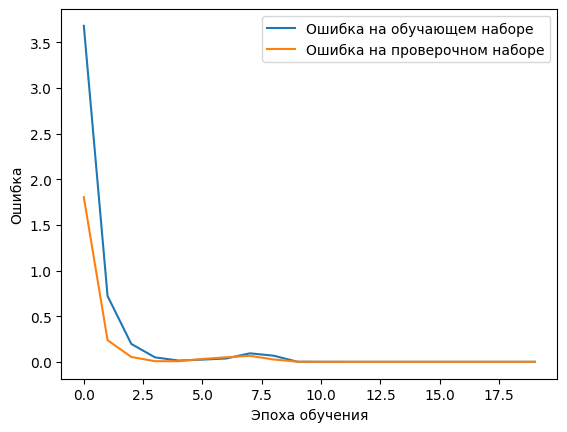

In [47]:
# Визуализация ошибка на обучающей выборке
plt.plot(history_resnet.history['loss'],
         label='Ошибка на обучающем наборе')

# Визуализация ошибка на проверочной выборке
plt.plot(history_resnet.history['val_loss'],
         label='Ошибка на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

### Проверка на тестовых данных
Проверяем работу модели на тестовом датасете и получаем точность на нем.

In [49]:
scores_small = model.evaluate(x_data_test,
                              y_data_test,
                              verbose=1
                              )

print('Процент верных ответов на тестовых данных размером 80 на 60:', round(scores_small[1],4) * 100, '%')

2/2 [==============================] - 0s 30ms/step - loss: 0.0581 - accuracy: 0.9844
Процент верных ответов на тестовых данных размером 80 на 60: 98.44000000000001 %


### Предсказание модели
Пробуем сделать предсказание модели и сравниваем его с правильным ответом.

In [51]:
predict_num = int(input('Введите номер интересующего пациента: '))
x = x_data_test[predict_num]
print(x.shape)

x = np.expand_dims(x, axis=0)
print(x.shape)

prediction = model.predict(x)
# print(prediction)

pred = np.argmax(prediction)
print(f'Распознан пациент: {pred}')
print(f'Настоящий пациент: {np.argmax(y_data_test[predict_num])}')

Введите номер интересующего пациента: 10
(60, 80, 3)
(1, 60, 80, 3)
1/1 [==============================] - 0s 24ms/step
Распознан пациент: 10
Настоящий пациент: 10


### Матрица ошибок
Для анализа полученной модели строим матрицу ошибок.

2/2 [==============================] - 0s 22ms/step


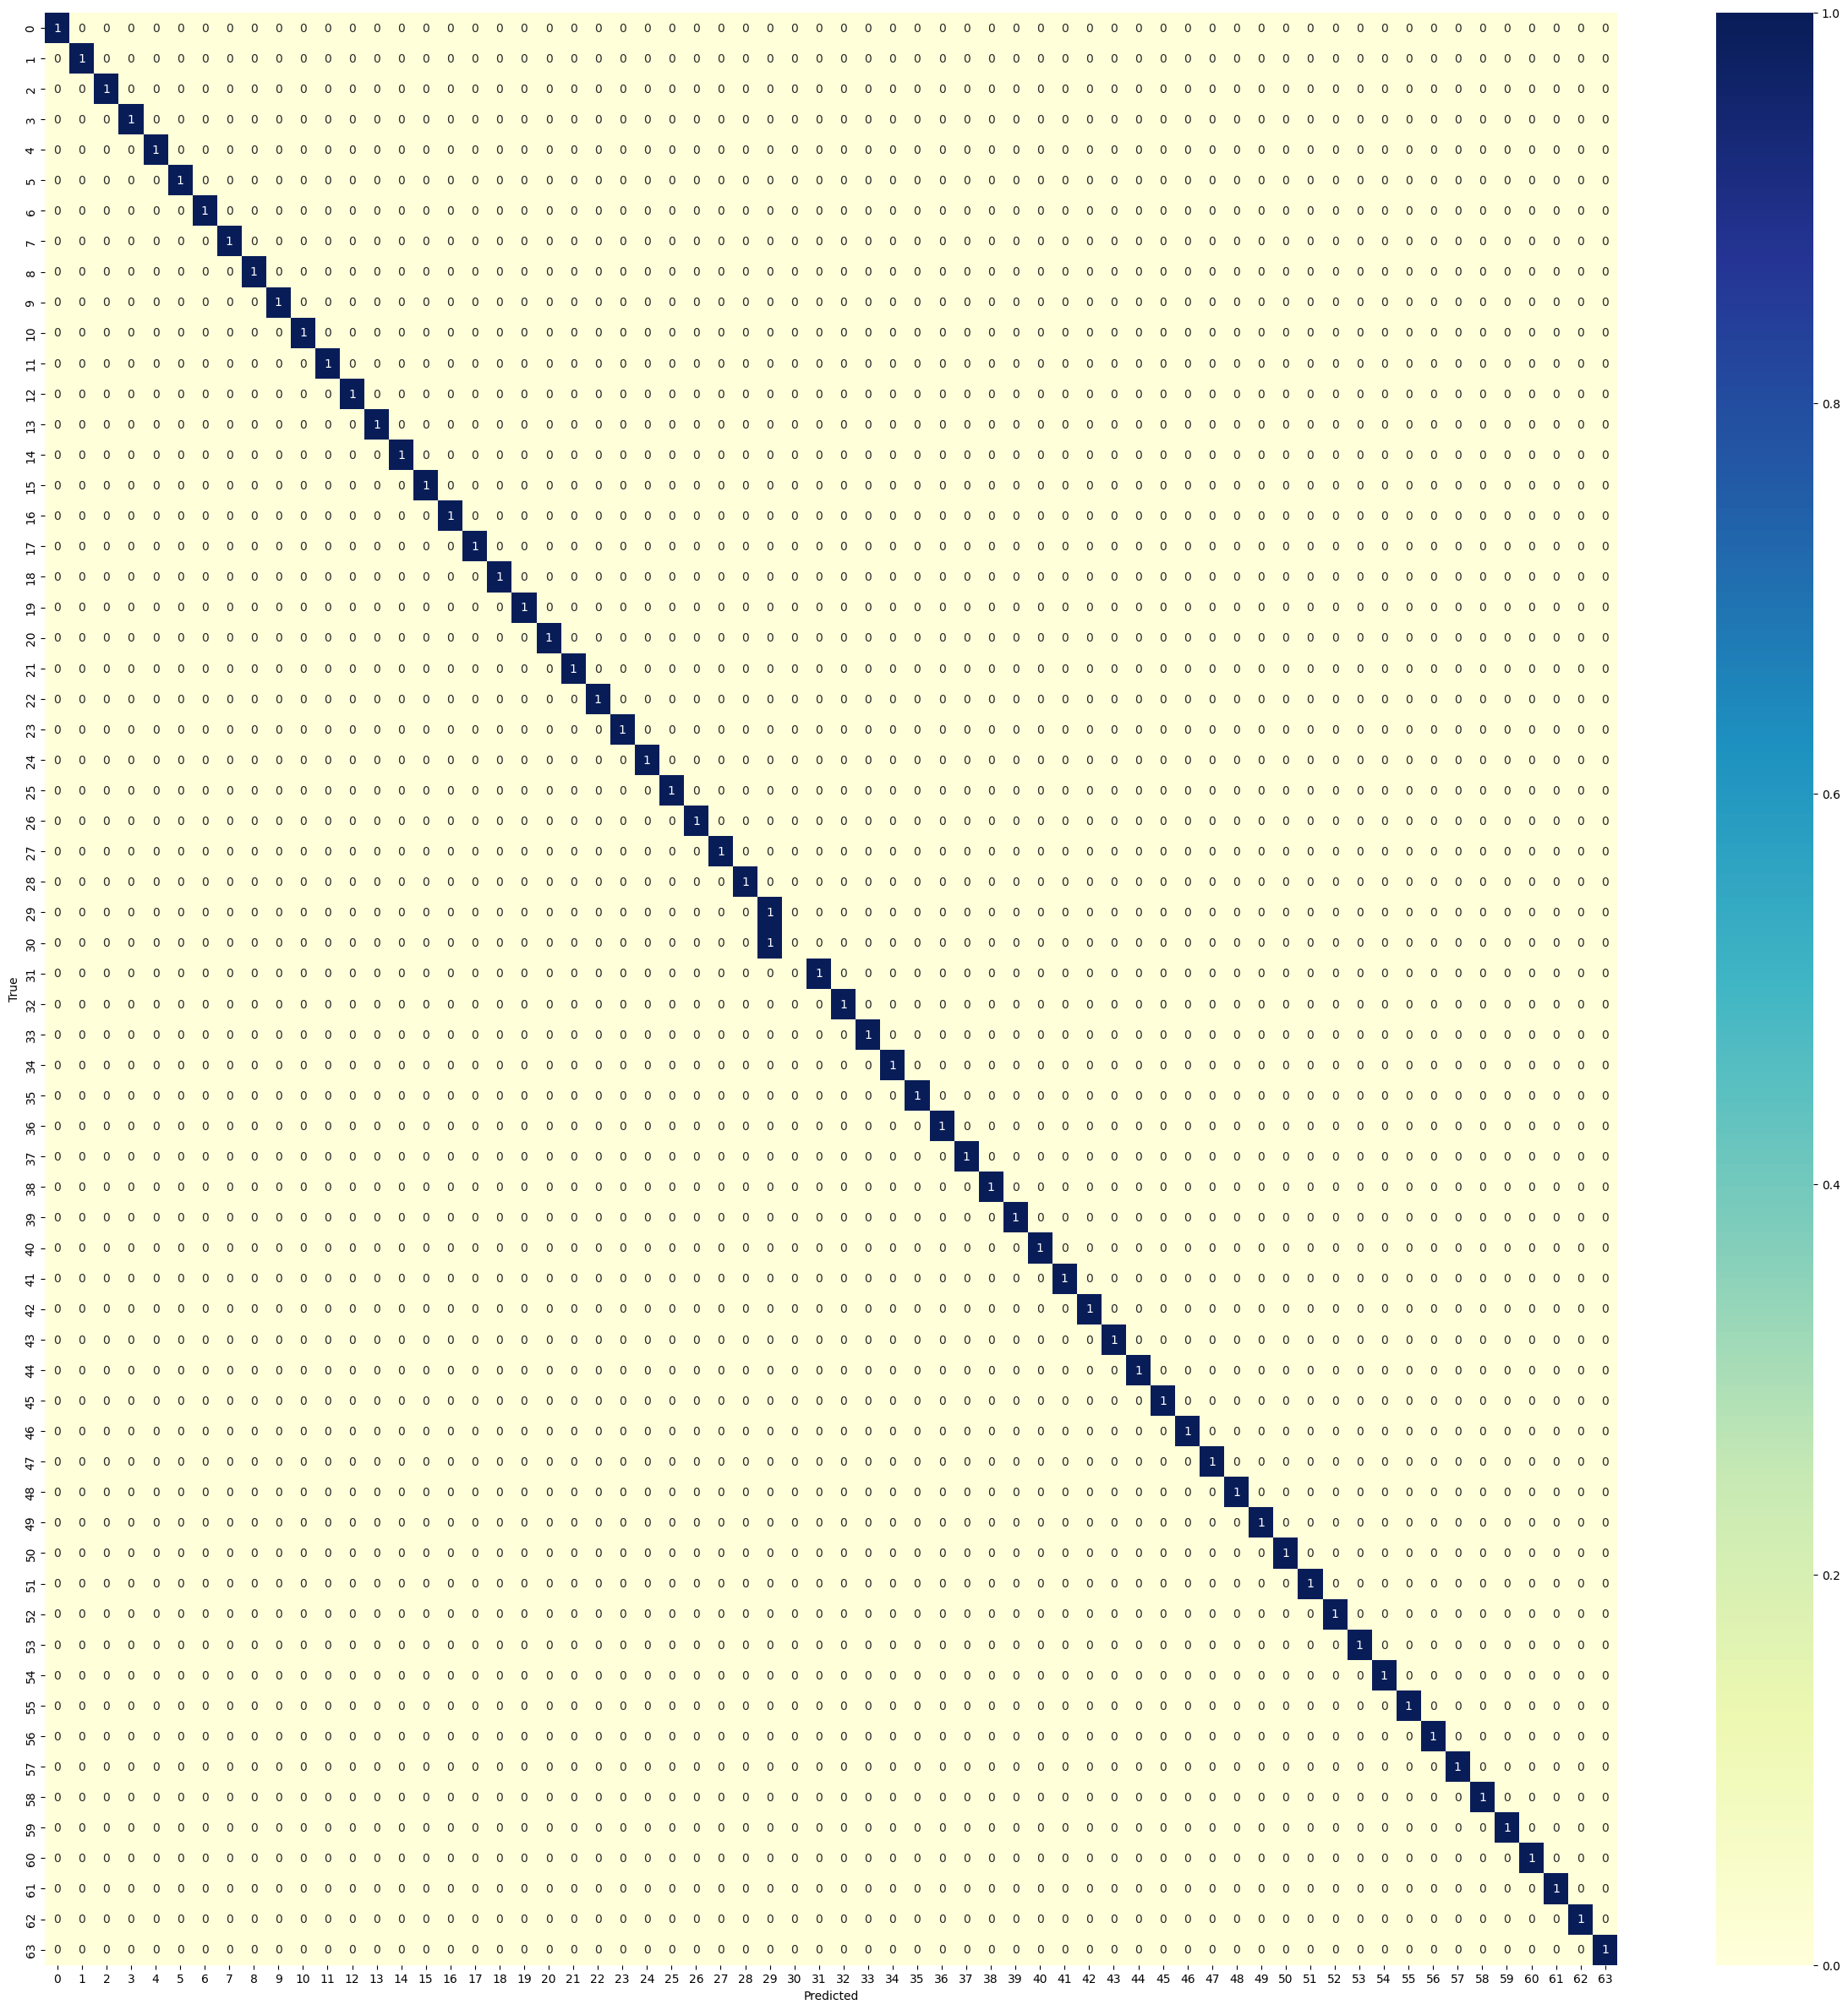

In [52]:
# Вычисление матрицы ошибок
y_pred = model.predict(x_data_test)
y_test_classes = [tf.argmax(y_data_test[i]).numpy() for i in range(len(y_data_test))]
y_pred_classes = [tf.argmax(y_pred[i]).numpy() for i in range(len(y_pred))]
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)

# Отображение матрицы ошибок в графическом виде
plt.figure(figsize=(30,30))
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **Выводы**

После проверки гипотез и проведения анализа графиков, полученных в результате экспериментов наилучшую точность показала нейронная сеть на основе предобученной модели ResNet50. В результате получена точность 100%.